In [1]:
!pip install tflearn

In [0]:
from __future__ import division, print_function, absolute_import

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import tflearn
from tflearn.data_utils import shuffle, to_categorical
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.estimator import regression
from tflearn.data_preprocessing import ImagePreprocessing
from tflearn.data_augmentation import ImageAugmentation




In [0]:
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

In [4]:
!pip install pydrive

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


In [6]:
from pydrive.drive import GoogleDrive

drive = GoogleDrive(gauth) # Create GoogleDrive instance with authenticated GoogleAuth instance

# Auto-iterate through all files in the root folder.
file_list = drive.ListFile({'q': "'1vQhQXjy4X9woILOTXeY3C-tz14xJkBQE' in parents and trashed=false"}).GetList()
for file1 in file_list:
  if file1['title'] == 'train.pkl':
     PIK = file1['id']
     print('title: %s, id: %s' % (file1['title'], file1['id']))
  elif file1['title'] == 'validation.pkl':
     VALIDPIK = file1['id']
     print('title: %s, id: %s' % (file1['title'], file1['id']))
  elif file1['title'] == 'test.pkl':
     TESTPIK = file1['id']
     print('title: %s, id: %s' % (file1['title'], file1['id']))


title: train.pkl, id: 13rbDW4JpED4Q97AOe1WquZCLCHWb7aI0
title: validation.pkl, id: 1wNCJDiwVMnoIL4alHl9De08b337WiEZP
title: test.pkl, id: 1gSKWAsH9YND3Y3_vNrXeXa-KRiPEGqBS


In [0]:
import pickle

In [0]:
X = []
Y = []
X_validate = []
Y_validate = []
X_test = []
Y_test = []

label_pairs ={
    'adho_mukha_svanasana':1,
    'bharadvajasana':2,
    'pasasana':3,
    'salamba_sarvangasana':4,
    'salamba_sirsasana':5,
    'virabhadrasana_I':6,
    'virabhadrasana_II':7,
    'virabhadrasana_III':8
}


In [0]:
dataFile = drive.CreateFile({'id': PIK}).GetContentFile('train.pkl')

In [0]:
testFile = drive.CreateFile({'id': TESTPIK}).GetContentFile('test.pkl')

In [0]:
validateFile = drive.CreateFile({'id': VALIDPIK}).GetContentFile('validation.pkl')

In [12]:

X_type = 'float64'

with open('train.pkl', "rb") as f:
    while True :
        try:
            record=pickle.load(f)
            X.append(record[0].astype(X_type))
            Y.append(label_pairs[record[1]])
        except EOFError:
            print('processing done!')
            break
            
print ("Train Data Size :" , len(X))


processing done!
Train Data Size : 6180


In [13]:
with open('validation.pkl', "rb") as f:
    while True :
        try:
            record=pickle.load(f)
            X_validate.append(record[0].astype(X_type))
            Y_validate.append(label_pairs[record[1]])
        except EOFError:
            print('processing done!')
            break
            
print ("Validation Data Size :" , len(X_validate))

processing done!
Validation Data Size : 1330


In [14]:
with open('test.pkl', "rb") as f:
    while True :
        try:
            record=pickle.load(f)
            X_test.append(record[0].astype(X_type))
            Y_test.append(label_pairs[record[1]])
        except EOFError:
            print('processing done!')
            break
            
print ("Test Data Size :" , len(X_test))


processing done!
Test Data Size : 265


In [0]:
model_name="siamese_skeletal_insights"

In [16]:
#convert to categorical variables
Y = to_categorical(Y, 9)
Y_validate = to_categorical(Y_validate, 9)
Y_test = to_categorical(Y_test, 9)

def tower_network(reuse = False):
    network = tflearn.input_data(shape=(64,64,3))
    network = tflearn.conv_2d(network, 32,1, activation='relu',reuse=reuse, scope='conv1')
    network = tflearn.conv_2d(network, 128,1, activation='relu',reuse=reuse, scope='conv9')
    network = tflearn.max_pool_2d(network, 2, strides=2)
    network = tflearn.fully_connected(network, 512, activation='relu',reuse=reuse, scope='fc1')
    network = tflearn.dropout(network, 0.5)
    return network
    
def similarity_network( net1, net2):
    num_classes = 9
    network = tflearn.merge([net1,net2], mode='concat', axis=1, name='Merge') # merge net1 and net2 networks
    # fully connected layers
    network = tflearn.fully_connected(network, 2048, activation='relu')
    network = tflearn.dropout(network, 0.5)
    network = tflearn.fully_connected(network, 2048, activation='relu')
    network = tflearn.dropout(network, 0.5)
    
    # softmax layers
    network = tflearn.fully_connected(network, num_classes, activation='softmax')
    
    return network

if __name__ == "__main__":
    
    X1 = X
                                             
    X2 = X_test
    
    T = Y
    
                
    # LABEL
    Y       = np.asarray(Y)
    
    #tower networks
    net1 = tower_network()
    net2 = tower_network(reuse=True)
    
    #similarity network
    network = similarity_network( net1, net2)
    #output layer
    #network = tflearn.regression(network, optimizer='sgd', loss='hinge_loss', learning_rate=0.02)
    network = tflearn.regression(network, optimizer='sgd', loss='categorical_crossentropy', learning_rate=0.02)

    #training
    model = tflearn.DNN(network)
    model.fit([X,X], Y,n_epoch=50)


Training Step: 4849  | total loss: 19.86526 | time: 21.013s
| SGD | epoch: 050 | loss: 19.86526 -- iter: 6144/6180
Training Step: 4850  | total loss: 19.92948 | time: 21.236s
| SGD | epoch: 050 | loss: 19.92948 -- iter: 6180/6180
--


In [19]:
# Training

start_time = time.time()
#training
model = tflearn.DNN(network)
model.fit([X,X], Y,n_epoch=50)

Training Step: 71  | time: 15.816s
| SGD | epoch: 001 | loss: 0.00000 -- iter: 4544/6180


KeyboardInterrupt: ignored

In [0]:
 model.save(model_name)
 print("Network trained and saved as "+model_name+" time taken: " , time.time() - start_time)



Network trained and saved as tflearn-v0.63.tfl. time taken:  2105.63618016243


In [0]:
#Predicting

test_images_and_labels = list(zip(X_test, Y_test))
correct_count = 0
wrong_count = 0
correct_indices = []
wrong_indices = []
preds = []
labels = []
total_predict_time = 0 ;

for index, (image, label) in enumerate(test_images_and_labels):
    imagedata = image[np.newaxis, :, :]
    predict_start_time = time.time()
    pred = model.predict(imagedata)
    total_predict_time=total_predict_time+(time.time()-predict_start_time)
    pred = pred[0].argmax(axis=0)
    label = label.argmax(axis=0)
    #print("Pred: {pred} Actual:{label}".format(pred=pred, label=label) )
    #print(int(pred))
    #print(int(label))
    preds = np.append(preds,pred)
    labels = np.append(labels,label)
    if int(pred) == int(label) :
        correct_count=correct_count+1
        correct_indices = np.append(correct_indices,int(index))
    else :
        wrong_count=wrong_count+1
        wrong_indices = np.append(wrong_indices,int(index))

accuracy=correct_count/(correct_count+wrong_count)
print(accuracy)
print(correct_count)
print(wrong_count)
print("Total Prediction Time :" + str(total_predict_time))


Pred: 7 Actual:7
Pred: 7 Actual:7
Pred: 7 Actual:7
Pred: 7 Actual:7
Pred: 7 Actual:7
Pred: 7 Actual:7
Pred: 5 Actual:7
Pred: 7 Actual:7
Pred: 7 Actual:7
Pred: 7 Actual:7
Pred: 7 Actual:7
Pred: 7 Actual:7
Pred: 7 Actual:7
Pred: 7 Actual:7
Pred: 7 Actual:7
Pred: 7 Actual:7
Pred: 2 Actual:7
Pred: 5 Actual:7
Pred: 7 Actual:7
Pred: 7 Actual:7
Pred: 7 Actual:7
Pred: 6 Actual:7
Pred: 7 Actual:7
Pred: 7 Actual:7
Pred: 7 Actual:7
Pred: 7 Actual:7
Pred: 7 Actual:7
Pred: 7 Actual:7
Pred: 7 Actual:7
Pred: 2 Actual:7
Pred: 7 Actual:7
Pred: 7 Actual:7
Pred: 7 Actual:7
Pred: 7 Actual:7
Pred: 7 Actual:7
Pred: 7 Actual:7
Pred: 7 Actual:7
Pred: 7 Actual:7
Pred: 8 Actual:8
Pred: 8 Actual:8
Pred: 8 Actual:8
Pred: 8 Actual:8
Pred: 8 Actual:8
Pred: 8 Actual:8
Pred: 8 Actual:8
Pred: 8 Actual:8
Pred: 2 Actual:8
Pred: 8 Actual:8
Pred: 8 Actual:8
Pred: 8 Actual:8
Pred: 8 Actual:8
Pred: 8 Actual:8
Pred: 8 Actual:8
Pred: 8 Actual:8
Pred: 8 Actual:8
Pred: 8 Actual:8
Pred: 8 Actual:8
Pred: 3 Actual:8
Pred: 5 Actual

In [0]:
import tensorflow as tf
from sklearn.metrics import confusion_matrix
conf_mat = np.matrix(tf.confusion_matrix(labels,preds,num_classes=8,dtype=tf.int32))
conf_mat = confusion_matrix(labels,preds)


In [0]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

[[24  3  1  0  0  0  0  0]
 [ 0 31  1  0  0  1  0  0]
 [ 0  3 21  0  1  0  0  1]
 [ 0  2  1 21  5  0  0  0]
 [ 0  1  0  2 39  0  0  1]
 [ 0  4  2  0  2 28  4  0]
 [ 0  2  0  0  2  1 33  0]
 [ 0  2  1  0  1  0  0 24]]
Confusion matrix, without normalization
[[24  3  1  0  0  0  0  0]
 [ 0 31  1  0  0  1  0  0]
 [ 0  3 21  0  1  0  0  1]
 [ 0  2  1 21  5  0  0  0]
 [ 0  1  0  2 39  0  0  1]
 [ 0  4  2  0  2 28  4  0]
 [ 0  2  0  0  2  1 33  0]
 [ 0  2  1  0  1  0  0 24]]
Normalized confusion matrix
[[0.85714286 0.10714286 0.03571429 0.         0.         0.
  0.         0.        ]
 [0.         0.93939394 0.03030303 0.         0.         0.03030303
  0.         0.        ]
 [0.         0.11538462 0.80769231 0.         0.03846154 0.
  0.         0.03846154]
 [0.         0.06896552 0.03448276 0.72413793 0.17241379 0.
  0.         0.        ]
 [0.         0.02325581 0.         0.04651163 0.90697674 0.
  0.         0.02325581]
 [0.         0.1        0.05       0.         0.05       0.7
  0.

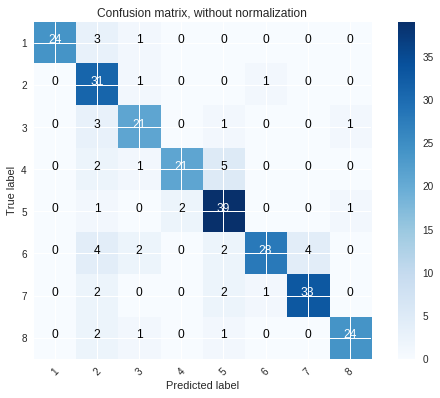

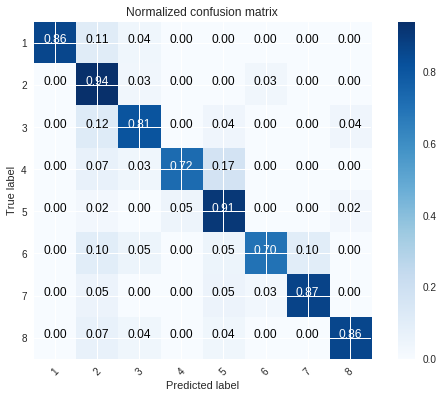

In [0]:
np.set_printoptions(threshold=np.nan)
class_names=['1','2','3','4','5','6','7','8']
# print(conf_mat)
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(conf_mat, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(conf_mat, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()